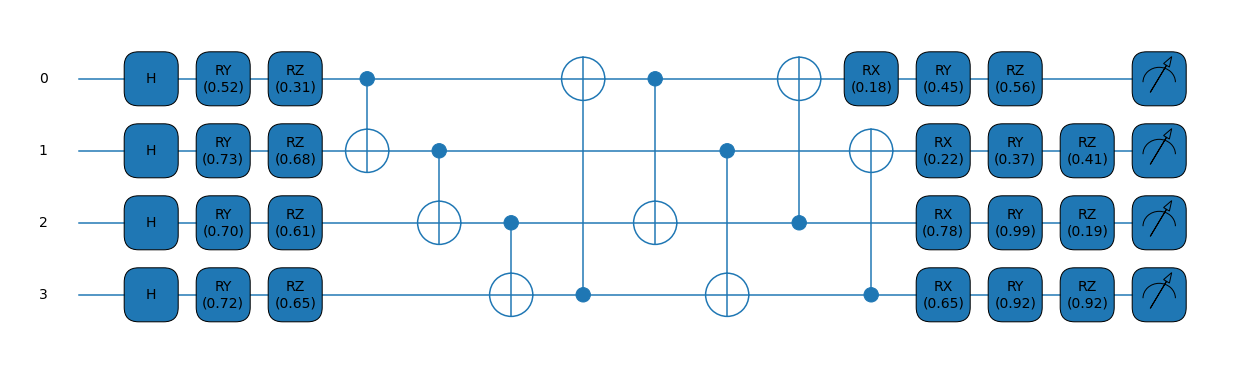

In [2]:
### Draw VQC circuit

import pennylane as qml

from pennylane import numpy as np

from matplotlib import pyplot as plt


qubit_count = 4

ANSATZ_LAYERS_COUNT = 1
ROTATIONS_COUNT = 3

features = np.random.random(qubit_count)

weights = np.random.random((ANSATZ_LAYERS_COUNT, ROTATIONS_COUNT, qubit_count), requires_grad=True)

wires_update = list(range(qubit_count))



dev = qml.device("default.qubit", wires=wires_update)

                          
def ansatz_circuit(params, wires_type):   
    # Entangling layer.
    for i in range(1, 3): 
        for j in range(len(wires_type)):
            if j + i < len(wires_type):
                qml.CNOT(wires=[wires_type[j], wires_type[j + i]])
            else:
                qml.CNOT(wires=[wires_type[j], wires_type[j + i - len(wires_type)]])

    # Variational layer.
    for i in range(len(wires_type)):
        qml.RX(params[0][i], wires=wires_type[i])
        qml.RY(params[1][i], wires=wires_type[i])
        qml.RZ(params[2][i], wires=wires_type[i])

@qml.qnode(dev, diff_method="parameter-shift")
def vqc_circuit(features, weights, wires_type):
    # Preproccess input data to encode the initial state.
    #qml.templates.AngleEmbedding(features, wires=wires_type)
    ry_params = [np.arctan(feature) for feature in features]
    rz_params = [np.arctan(feature**2) for feature in features]
    for i in range(len(wires_type)):
        qml.Hadamard(wires=wires_type[i])
        qml.RY(ry_params[i], wires=wires_type[i])
        qml.RZ(rz_params[i], wires=wires_type[i])

    #Variational block.
    qml.layer(ansatz_circuit, ANSATZ_LAYERS_COUNT, weights, wires_type=wires_type)
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in wires_type]
                          
                          
fig, ax = qml.draw_mpl(vqc_circuit, decimals=2)(features, weights, wires_update)
plt.show()

In [3]:
### Template comparison

In [4]:
def ansatz_circuit_alt(weights, qubits):
    
    # Entangling layer
    
    if len(qubits) > 1:
        
        cnot_pairs = zip(qubits, qubits[1:] + [qubits[0]])
        
        for control_qubit, target_qubit in cnot_pairs:
            
            qml.CNOT(wires=[control_qubit, target_qubit])    

    # Variational layer
    
    for qubit, weight_rx, weight_ry, weight_rz in zip(qubits, *weights):
    
        qml.RX(weight_rx, wires=qubit)
        qml.RY(weight_ry, wires=qubit)
        qml.RZ(weight_rz, wires=qubit)


def vqc_circuit_alt(features, weights, qubits):    
    
    # Input features encoding with angles
    
    ry_angles = (np.arctan(feature) for feature in features)
    rz_angles = (np.arctan(feature**2) for feature in features)
    
    for qubit, ry_angle, rz_angle in zip(qubits, ry_angles, rz_angles):
                
        qml.Hadamard(wires=qubit)
        qml.RY(ry_angle, wires=qubit)
        qml.RZ(rz_angle, wires=qubit)

    # Variational block
    
    qml.layer(ansatz_circuit_alt, ANSATZ_LAYERS_COUNT, weights, qubits=qubits)
    
    return [qml.expval(qml.PauliZ(wires=qubit)) for qubit in qubits]

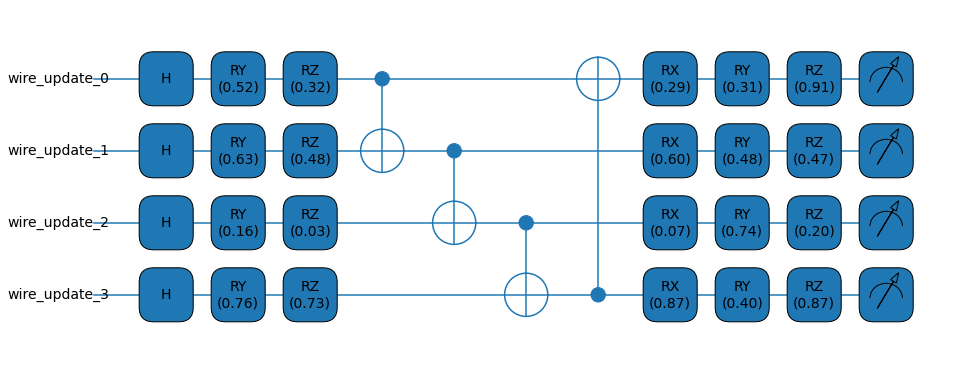

In [5]:
# Draw VQC Circuit

qubit_count = 4

device_type = "default.qubit"

ANSATZ_LAYERS_COUNT = 1

wires_update = [f"wire_update_{i}" for i in range(qubit_count)]

features = np.random.random(qubit_count)
weights = np.random.random((ANSATZ_LAYERS_COUNT, 
                            ROTATIONS_COUNT, 
                            qubit_count), 
                           requires_grad=True)



vqc_device = qml.device(device_type, wires=wires_update)

vqc_qnode_alt = qml.QNode(vqc_circuit_alt, vqc_device)

fig, ax = qml.draw_mpl(vqc_qnode_alt, decimals=2)(features, weights, wires_update)
plt.show()

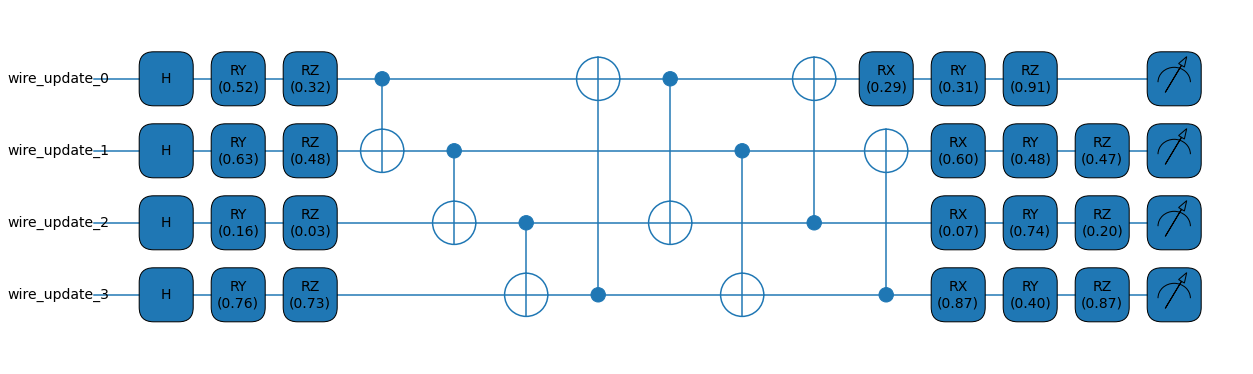

In [6]:
vqc_qnode = qml.QNode(vqc_circuit, vqc_device)

fig, ax = qml.draw_mpl(vqc_qnode, decimals=2)(features, weights, wires_update)
plt.show()

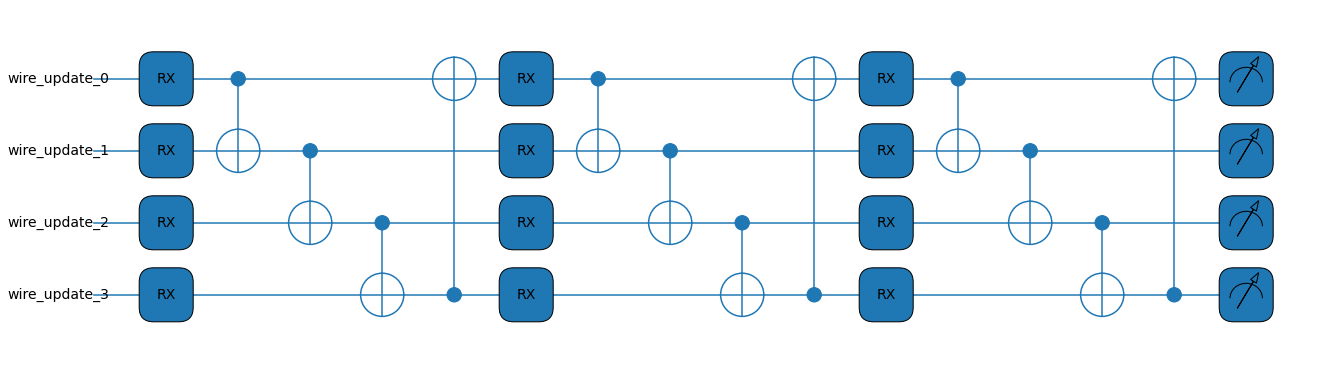

In [7]:
def basic_entangler_circuit(weights, qubits):    
    
    qml.BasicEntanglerLayers(weights, wires=qubits)
    
    return [qml.expval(qml.PauliZ(wires=qubit)) for qubit in qubits]


basic_entangler_node = qml.QNode(basic_entangler_circuit, vqc_device)


fig, ax = qml.draw_mpl(basic_entangler_node, decimals=2, expansion_strategy='device')(weights, wires_update)
plt.show()